# Multiple layers with `Flux.jl`

In a previous notebook, we saw that one layer of neurons wasn't enough to distinguish between three types of fruit, apples, bananas, **and** grapes, since the data was quite complex. To solve this problem, we need to use more layers, so heading into the territory of **deep learning**!

By adding another layer between the inputs and the output neurons, a so-called "hidden layer", we will get our first serious **neural network**, looking something like this:

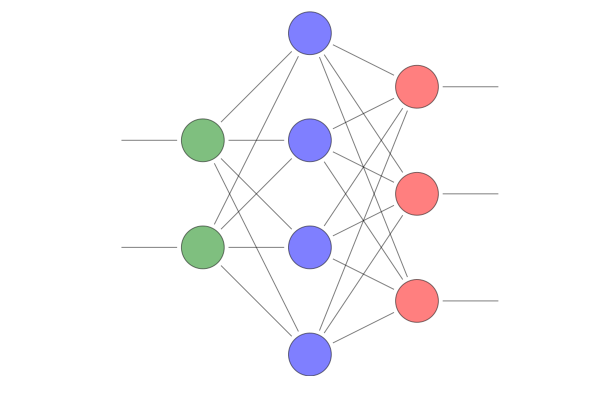

In [1]:
include("draw_neural_net.jl")
draw_network([2, 4, 3])

We will continue to use two input data and try to classify into three types, so we will have three output neurons. We have chosen to add a single "hidden layer" in between, and have arbitrarily chosen to put 4 neurons there.

## Read in and process data

As before, let's load some pre-processed data using code we've seen in the previous notebook.

In [2]:
using Flux
using Flux: onehot

In [3]:
using CSV

apples_1 = CSV.read("data/Apple_Golden_1.dat", delim='\t')
apples_2 = CSV.read("data/Apple_Golden_2.dat", delim='\t')
apples_3 = CSV.read("data/Apple_Golden_3.dat", delim='\t')
bananas = CSV.read("data/Banana.dat", delim='\t')
grapes_1 = CSV.read("data/Grape_White.dat", delim='\t')
grapes_2 = CSV.read("data/Grape_White_2.dat", delim='\t');

apples = vcat(apples_1, apples_2, apples_3)
grapes = vcat(grapes_1, grapes_2);

In [4]:
col1 = :red
col2 = :blue

x_apples  = [ [apples_1[i, col1], apples_1[i, col2]] for i in 1:size(apples_1)[1] ]
append!(x_apples, [ [apples_2[i, col1], apples_2[i, col2]] for i in 1:size(apples_2)[1] ])
append!(x_apples, [ [apples_3[i, col1], apples_3[i, col2]] for i in 1:size(apples_3)[1] ])

x_bananas = [ [bananas[i, col1], bananas[i, col2]] for i in 1:size(bananas)[1] ]

x_grapes = [ [grapes_1[i, col1], grapes_1[i, col2]] for i in 1:size(grapes_1)[1] ]
append!(x_grapes, [ [grapes_2[i, col1], grapes_2[i, col2]] for i in 1:size(grapes_2)[1] ])

xs = vcat(x_apples, x_bananas, x_grapes);

We now we wish to classify the three types of fruit, so we again use one-hot vectors to represent the desired outputs $y^{(i)}$:

In [5]:
labels = [ones(length(x_apples)); 2*ones(length(x_bananas)); 3*ones(length(x_grapes))];

ys = [onehot(label, 1:3) for label in labels];  # onehotbatch(labels, 1:3)

The input data is in `xs` and the one-hot vectors are in `ys`.

## Multiple layers in Flux

Let's tell Flux what structure we want the network to have. We first specify the number of neurons in each layer, and then construct each layer as a `Dense` layer:

In [6]:
inputs = 2
hidden = 4
outputs = 3

layer1 = Dense(inputs, hidden, σ)
layer2 = Dense(hidden, outputs, σ)

Dense(4, 3, NNlib.σ)

To stitch together multiple layers to make a multi-layer network, we use Flux's `Chain` function:

In [8]:
model = Chain(layer1, layer2)

Chain(Dense(2, 4, NNlib.σ), Dense(4, 3, NNlib.σ))

**Exercise**: What is the internal structure and sub-structure of this `model` object?

**Solution**:

In [19]:
model.layers

2-element Array{Any,1}:
 Dense(2, 4, NNlib.σ)
 Dense(4, 3, NNlib.σ)

So `model` understands that it consists of two layers, and:

In [10]:
model.layers[1].W

Tracked 4×2 Array{Float64,2}:
  0.166479  -0.755728
  0.556201  -0.895146
 -0.86245    0.930831
  0.491125  -0.32931 

In [11]:
model.layers[1].b

Tracked 4-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0

So both the layers have their own `W` and `b`, just as you might expect -- `Flux` wraps all this up in a way that is structured but easy to use.  

In particular, using `params` returns *all* the parameters hidden inside the `model` object, that is the pairs $(W, b)$ from both layers:

In [13]:
params(model)

4-element Array{Any,1}:
 param([0.166479 -0.755728; 0.556201 -0.895146; -0.86245 0.930831; 0.491125 -0.32931])                                      
 param([0.0, 0.0, 0.0, 0.0])                                                                                                
 param([0.0390887 -0.579978 -0.26604 -0.526036; 0.442619 0.75452 0.600319 0.100004; -0.308633 0.750142 -0.570498 0.0782689])
 param([0.0, 0.0, 0.0])                                                                                                     

## Training the model

We have now set up a model and we have some training data.
How do we train the model on the data?
    
The amazing thing is that the rest of the code in `Flux` is **exactly the same as before**. This is possible thanks to the design of Julia itself, and of the `Flux` package.

**Exercise**: Train the model as before, now using the popular `ADAM` optimizer. You may need to train the network for longer than before, since we have many more parameters.

**Solution:**

In [15]:
loss(x, y) = Flux.mse(model(x), y)

loss (generic function with 1 method)

In [16]:
data = zip(xs, ys);

In [17]:
opt = ADAM(params(model), 0.02)

(::#71) (generic function with 1 method)

In [ ]:
for i in 1:1000
    Flux.train!(loss, data, opt)
end

Let's check the final values of the parameters:

In [22]:
params(model)

4-element Array{Any,1}:
 param([-6.83212 -64.0499; -18.3242 8.79785; -17.0298 62.6678; 10.5581 -5.30668])                                
 param([19.4188, -6.89873, -11.4249, 16.3096])                                                                   
 param([-35.7559 0.0632858 -11.1558 -7.74843; 81.9684 -1.42289 -338.719 8.36712; 27.3065 20.236 45.5364 13.5276])
 param([17.8872, -26.4756, -45.7942])                                                                            

## Visualizing the results

What does this neural network represent? It is simply a more complicated function with two inputs and three outputs, i.e. a function $f: \mathbb{R}^2 \to \mathbb{R}^3$. 
Before, with a single layer, each component of the function $f$ basically corresponded to a hyperplane; now it will instead be a **more complicated nonlinear function** of the input data!

**Exercise**: Visualize each component of the output separately as a heatmap and/or contours superimposed on the data. Interpret the results.

**Solution**:

In [25]:
coords = 0:0.01:0.8

heatmap(coords, coords, (x,y)->model([x,y]).data[1])
#contour!(coords, coords, (x,y)->model([x,y]).data[1], levels=[0.5, 0.501], lw=3)

scatter!(first.(x_apples), last.(x_apples), m=:cross, label="apples")
scatter!(first.(x_bananas), last.(x_bananas), m=:circle, label="bananas")
scatter!(first.(x_grapes), last.(x_grapes), m=:square, label="grapes")

xlims!(0.4, 0.8)
ylims!(0.1, 0.5)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0.4 
 
 
 0.5 
 
 
 0.6 
 
 
 0.7 
 
 
 0.8 
 
 
 0.1 
 
 
 0.2 
 
 
 0.3 
 
 
 0.4 
 
 
 0.5 
 
 
<image width="988" height="737" xlink:href="data:image/png;base64,
iVBORw0KGgoAAAANSUhEUgAAA9wAAALhCAYAAACtw6zaAAAgAElEQVR4nO3dy5Jdh33d4f8+e/cF
fQFAEgQBUpSoC0uynMgqjRxXKi+Qh8gb5E0zziRlJ46rVGWLFClS4gXoPhlgkIpLsb2OuPo0oO8b
r31rdB/0D3uA5b+881/385q7lw9wL28q8wY8AgAAwNHsjn0DAAAA8CYS3AAAAFAguAEAAKBAcAMA
AECB4AYAAIACwQ0AAAAFghsAAAAKBDcAAAAUCG4AAAAo2I59A6+N/bFvAAAAgNeJN9wAAABQILgB
AACgQHADAABAgeAGAACAAsENAAAABYIbAAAACgQ3AAAAFAhuAAAAKNiOfQN/zP7YN/AG8jUFAAC4
W95wAwAAQIHgBgAAgALBDQAAAAWCGwAAAAoENwAAABQIbgAAACgQ3AAAAFAguAEAAKBgO/YNHMX+
2DcAAADAm84bbgAAACgQ3AAAAFAguAEAAKBAcAMAAECB4AYAAIACwQ0AAAAFghsAAAAKBDcAAAAU
bMe+AQ6zP/YNAAAA8C/yhhsAAAAKBDcAAAAUCG4AAAAoENwAAABQILgBAACgQHADAABAgeAGAACA
AsENAAAABdtdXGT/2l8AAAAAMt5wAwAAQIHgBgAAgALBDQAAAAWCGwAAAAoENwAAABQIbgAAACgQ
3AAAAFAguAEAAKBgO/YN8Mr+2DcAAADAd8obbgAAACgQ3AAAAFAguAEAAKBAcAMAAECB4AYAAIAC
wQ0AAAAFghsAAAAKBDcAAAAUbIcctP+u7+LOLwAAAABd3nADAABAgeAGAACAAsENAAAABYIbAAAA
CgQ3AAAAFAhuAAAAKBDcAAAAUCC4AQAAoGA79g28qfbHvgEAAACOyhtuAAAAKBDcAAAAUCC4AQAA
oEBwAwAAQIHgBgAAgALBDQAAAAWCGwAAAAoENwAAABRs+7u4yp1cBAAAAO4Pb7gBAACgQHADAABA
geAGAACAAsENAAAABYIbAAAACgQ3AAAAFAhuAAAAKBDcAAAAULAd+wZeF/tj3wAAAACvFW+4AQAA
oEBwAwAAQIHgBgAAgALBDQAAAAWCGwAAAAoENwAAABQIbgAAACgQ3AAAAFAguAEAAKBgO+io/Xd8
FwAAAPCG8YYbAAAACgQ3AAAAFAhuAAAAKBDcAAAAUCC4AQAAoEBwAwAAQIHgBgAAgALBDQAAAAXb
sW/gGPbHvgEAAADeeN5wAwAAQIHgBgAAgALBDQAAAAWCGwAAAAoENwAAABQIbgAAACgQ3AAAAFAg
uAEAAKBAcAMAAECB4AYAAIACwQ0AAAAFghsAAAAKBDcAAAAUCG4AAAAoENwAAABQILgBAACgQHAD
AABAwTb7Y9/Cn+4NeAQAAADeMN5wAwAAQIHgBgAAgALBDQAAAAWCGwAAAAoENwAAABQIbgAAACgQ
3AAAAFAguAEAAKBAcAMAAECB4AYAAIACwQ0AAAAFghsAAAAKBDcAAAAUCG4AAAAoENwAAABQILgB
AACgQHADAABAwXbsG/hj9se+AQAAAPgTecMNAAAABYIbAAAACgQ3AAAAFAhuAAAAKBDcAAAAUCC4
AQAAoEBwAwAAQIHgBgAAgALBDQAAAAWCGwAAAAoENwAAABQIbgAAACgQ3AAAAFAguAEAAKBAcAMA
AECB4AYAAIACwQ0AAAAF211cZH8XFwEAAIB7xBtuAAAAKBDcAAAAUCC4AQAAoEBwAwAAQIHgBgAA
gALBDQAAAAWCGwAAAAoENwAAABQIbgAAACgQ3AAAAFAguAEAAKBAcAMAAECB4AYAAIACwQ0AAAAF
ghsAAAAKBDcAAAAUCG4AAAAoENwAAABQILgBAACgQHADAABAgeAGAACAAsENAAAABYIbAAAACgQ3
AAAAFAhuAAAAKBDcAAAAUCC4AQAAoGA75KD9d30XAAAA8IbxhhsAAAAKBDcAAAAUCG4AAAAoENwA
AABQILgBAACgQHADAABAgeAGAACAAsENAAAABYIbAAAACgQ3AAAAFAhuAAAAKBDcAAAAUCC4AQAA
oEBwAwAAQIHgBgAAgALBDQAAAAWCGwAAAAq2/bHvAAAAAN5A3nADAABAgeAGAACAAsENAAAABYIb
AAAACgQ3AAAAFAhuAAAAKBDcAAAAUCC4AQAAoEBwAwAAQIHgBgAAgALBDQAAAAWCGwAAAAoENwAA
ABQIbgAAACgQ3AAAAFAguAEAAKBAcAMAAECB4AYAAIACwQ0AAAAFghsAAAAKBDcAAAAUCG4AAAAo
ENwAAABQILgBAACgQHADAABAgeAGAACAAsENAAAABYIbAAAACgQ3AAAAFAhuAAAAKBDcAAAAUCC4
AQAAoEBwAwAAQIHgBgAAgALBDQAAAAWCGwAAAAoENwAAABQIbgAAACgQ3AAAAFAguAEAAKBAcAMA
AECB4AYAAIACwQ0AAAAFghsAAAAKBDcAAAAUCG4AAAAoENwAAABQILgBAACgQHADAABAgeAGAACA
AsENAAAABYIbAAAACgQ3AAAAFGzHvgEAAAA4hqV8fm+4AQAAoEBwAwAAQIHgBgAAgALBDQAAAAWC
GwAAAAoENwAAABQIbgAAACgQ3AAAAFCwHfsGAAAA+POwHPsG/rnyDXnDDQAAAAWCGwAAAAoENwAA
ABQIbgAAACgQ3AAAAFAguAEAAKBAcAMAAECB4AYAAIACwQ0AAAAF27FvAAAAgH/dcuwb+C6ED3Hf
njm9H2+4AQAAoEBwAwAAQIHgBgAAgALBDQAAAAWCGwAAAAoENwAAABQIbgAAACgQ3AAAAFCwHfsG
AAAA2pZj38B3ofwQd/E1al8jPn94QHp+b7gBAACgQHADAABAgeAGAACAAsENAAAABYIbAAAACgQ3
AAAAFAhuAAAAKBDcAAAAULAd+wYAAIA3y3LsG/hjyjd1H5+5fU/LARdID4n34QHpG+hd+fwAAADA
v4HgBgAAgALBDQAAAAWCGwAAAAoENwAAABQIbgAAACgQ3AAAAFAguAEAAKBgO/YNAAAA/6/l2Dfw
pzrgAe7bM9/F/SzhRdJ7ivfl+5mZ2YUHxftsPmt4wFa+HwAAAODfQHADAABAgeAGAACAAsENAAAA
BYIbAAAACgQ3AAAAFAhuAAAAKBDcAAAAULAd+wYAAOC7tBz7Br4L5Ydof43u4s8gvkZ4QHr+3QEP
nR6yhAekb1fX9PwHPPMWHrOGD3Gy7LP9LtufrdneG24AAAAoENwAAABQILgBAACgQHADAABAgeAG
AACAAsENAAAABYIbAAAACgQ3AAAAFGzHvgEAAF5fy7Fv4I8p39R9fOb2PS3hBQ65n/SY9J7SN427
9PwHPHR6zBrut3S/20f70wNe357ubqP9WXhPD7abaH+xZvvLkxfR3htuAAAAKBDcAAAAUCC4AQAA
oEBwAwAAQIHgBgAAgALBDQAAAAWCGwAAAAoENwAAABRs2X8jzp+T5dg3AABvuDfi79rwIe7jM7fv
aTngAukh8b7857Y74JnTY9b0/OGrxi28n23Jy+okvKfTXXaNs/U22p+H+4v1JtrPzFxsL6P99ek3
0f7R+VfR/vHll9H+4cMvor033AAAAFAguAEAAKBAcAMAAECB4AYAAIACwQ0AAAAFghsAAAAKBDcA
AAAUCG4AAAAo2I59

We see that the first component, which is supposed to separate apples from non-apples, has been able to learn a set that has a much more complicated shape than simply a hyperplane: the hyperplane has been bent round. Sometimes it's able to encapsulate all the apple data, while sometimes it isn't, depending on how well it learnt.

In [26]:
coords = 0:0.01:1

#contour(coords, coords, (x,y)->model([x,y]).data[2], levels=[0.5, 0.501], lw=3)
heatmap(coords, coords, (x,y)->model([x,y]).data[2])

scatter!(first.(x_apples), last.(x_apples), m=:cross, label="apples")
scatter!(first.(x_bananas), last.(x_bananas), m=:circle, label="bananas")
scatter!(first.(x_grapes), last.(x_grapes), m=:square, label="grapes")

xlims!(0.4, 0.8)
ylims!(0.1, 0.5)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0.4 
 
 
 0.5 
 
 
 0.6 
 
 
 0.7 
 
 
 0.8 
 
 
 0.1 
 
 
 0.2 
 
 
 0.3 
 
 
 0.4 
 
 
 0.5 
 
 
<image width="1232" height="919" xlink:href="data:image/png;base64,
iVBORw0KGgoAAAANSUhEUgAABNAAAAOXCAYAAADlyLy/AAAbuUlEQVR4nOzau4vlZx3H8efsnI1L
JKAJxEZUTGEjFioBFSzUSuy0tJCAIgr+IYJoZSVoIWgQQUW8VV5QwRsJUQPR6BoTvGRjNtHNXmbm
HBvtwhu+a9azm7xe9ec3v2fgFHPe82zW2u4XAAAAAPC8zhz6AAAAAABwMxPQAAAAACAIaAAAAAAQ
BDQAAAAACAIaAAAAAAQBDQAAAACCgAYAAAAAQUADAAAAgCCgAQAAAEAQ0AAAAAAgCGgAAAAAEAQ0
AAAAAAgCGgAAAAAEAQ0AAAAAgoAGAAAAAEFAAwAAAIAgoAEAAABAENAAAAAAIAhoAAAAABAENAAA
AAAIAhoAAAAABAENAAAAAIKABgAAAABBQAMAAACAIKABAAAAQBDQAAAAACAIaAAAAAAQBDQAAAAA
CAIaAAAAAAQBDQAAAACCgAYAAAAAQUADAAAAgCCgAQAAAEAQ0AAAAAAgCGgAAAAAEAQ0AAAAAAgC
GgAAAAAEAQ0AAAAAgoAGAAAAAEFAAwAAAIAgoAEAAABAENAAAAAAIAhoAAAAABAENAAAAAAIAhoA
AAAABAENAAAAAIKABgAAAABBQAMAAACAIKABAAAAQBDQAAAAACAIaAAAAAAQBDQAAAAACAIaAAAA
AAQBDQAAAACCgAYAAAAAQUADAAAAgCCgAQAAAEAQ0AAAAAAgCGgAAAAAEAQ0AAAAAAgCGgAAAAAE
AQ0AAAAAgoAGAAAAAEFAAwAAAIAgoAEAAABAENAAAAAAIAhoAAAAABAENAAAAAAIAhoAAAAABAEN
AAAAAIKABgAAAABBQAMAAACAIKABAAAAQBDQAAAAACAIaAAAAAAQBDQAAAAACAIaAAAAAAQBDQAA
AACCgAYAAAAAQUADAAAAgCCgAQAAAEAQ0AAAAAAgCGgAAAAAEAQ0AAAAAAgCGgAAAAAEAQ0AAAAA
goAGAAAAAEFAAwAAAIAgoAEAAABAENAAAAAAIAhoAAAAABAENAAAAAAIAhoAAAAABAENAAAAAIKA
BgAAAABBQAMAAACAIKABAAAAQBDQAAAAACAIaAAAAAAQBDQAAAAACAIaAAAAAAQBDQAAAACCgAYA
AAAAQUADAAAAgCCgAQAAAEAQ0AAAAAAgCGgAAAAAEAQ0AAAAAAgCGgAAAAAEAQ0AAAAAgoAGAAAA
AEFAAwAAAIAgoAEAAABAENAAAAAAIAhoAAAAABAENAAAAAAIAhoAAAAABAENAAAAAIKABgAAAABB
QAMAAACAIKABAAAAQBDQAAAAACAIaAAAAAAQBDQAAAAACAIaAAAAAAQBDQAAAACCgAYAAAAAQUAD
AAAAgCCgAQAAAEAQ0AAAAAAgCGgAAAAAEAQ0AAAAAAgCGgAAAAAEAQ0AAAAAgoAGAAAAAEFAAwAA
AIAgoAEAAABAENAAAAAAIAhoAAAAABAENAAAAAAIAhoAAAAABAENAAAAAIKABgAAAABBQAMAAACA
IKABAAAAQBDQAAAAACAIaAAAAAAQBDQAAAAACAIaAAAAAAQBDQAAAACCgAYAAAAAQUADAAAAgCCg
AQAAAEAQ0AAAAAAgCGgAAAAAEAQ0AAAAAAgCGgAAAAAEAQ0AAAAAgoAGAAAAAEFAAwAAAIAgoAEA
AABAENAAAAAAIAhoAAAAABAENAAAAAAIAhoAAAAABAENAAAAAIKABgAAAABBQAMAAACAIKABAAAA
QBDQAAAAACAIaAAAAAAQBDQAAAAACAIaAAAAAAQBDQAAAACCgAYAAAAAQUADAAAAgCCgAQAAAEAQ
0AAAAAAgCGgAAAAAEAQ0AAAAAAgCGgAAAAAEAQ0AAAAAgoAGAAAAAEFAAwAAAIAgoAEAAABAENAA
AAAAIAhoAAAAABAENAAAAAAIAhoAAAAABAENAAAAAIKABgAAAABBQAMAAACAIKABAAAAQBDQAAAA
ACAIaAAAAAAQBDQAAAAACAIaAAAAAAQBDQAAAACCgAYAAAAAQUADAAAAgCCgAQAAAEAQ0AAAAAAg
CGgAAAAAEAQ0AAAAAAgCGgAAAAAEAQ0AAAAAgoAGAAAAAEFAAwAAAIAgoAEAAABAENAAAAAAIAho
AAAAABAENAAAAAAIAhoAAAAABAENAAAAAIKABgAAAABBQAMAAACAIKABAAAAQBDQAAAAACAIaAAA
AAAQBDQAAAAACAIaAAAAAAQBDQAAAACCgAYAAAAAQUADAAAAgCCgAQAAAEAQ0AAAAAAgCGgAAAAA
EAQ0AAAAAAgCGgAAAAAEAQ0AAAAAgoAGAAAAAEFAAwAAAIAgoAEAAABAENAAAAAAIAhoAAAAABAE
NAAAAAAIAhoAAAAABAENAAAAAIKABgAAAABBQAMAAACAIKABAAAAQBDQAAAAACAIaAAAAAAQBDQA
AAAACAIaAAAAAAQBDQAAAACCgAYAAAAAQUADAAAAgCCgAQAAAEAQ0AAAAAAgCGgAAAAAEAQ0AAAA
AAgCGgAAAAAEAQ0AAAAAgoAGAAAAAEFAAwAAAIAgoAEAAABAENAAAAAAIAhoAAAAABAENAAAAAAI
AhoAAAAABAENAAAAAIKABgAAAABBQAMAAACAIKABAAAAQBDQAAAAACAIaAAAAAAQBDQAAAAACAIa
AAAAAAQBDQAAAACCgAYAAAAAQUADAAAAgCCgAQAAAEAQ0AAAAAAgCGgAAAAAEAQ0AAAAAAgCGgAA
AAAEAQ0AAAAAgoAGAAAAAEFAAwAAAIAgoAEAAABAENAAAAAAIAhoAAAAABAENAAAAAAIAhoAAAAA
BAENAAAAAIKABgAAAABBQAMAAACAIKABAAAAQBDQAAAAACAIaAAAAAAQBDQAAAAACAIaAAAAAAQB
DQAAAACCgAYAAAAAQUADAAAAgCCgAQAAAEAQ0AAAAAAgCGgAAAAAEAQ0AAAAAAgCGgAAAAAEAQ0A
AAAAgoAGAAAAAEFAAwAAAIAgoAEAAABAENAAAAAAIAhoAAAAABAENAAAAAAIAhoAAAAABAENAAAA
AIKABgAAAABBQAMAAACAIKABAAAAQBDQAAAAACAIaAAAAAAQBDQAAAAACAIaAAAAAAQBDQAAAACC
gAYAAAAAQUADAAAAgCCgAQAAAEAQ0AAAAAAgCGgAAAAAEAQ0AAAAAAgCGgAAAAAEAQ0AAAAAgoAG
AAAAAEFAAwAAAIAgoAEAAABAENAAAAAAIAhoAAAAABAENAAAAAAIAhoAAAAABAENAAAAAIKABgAA
AABBQAMAAACAIKABAAAAQBDQAAAAACAIaAAAAAAQBDQAAAAACAIaAAAAAAQBDQAAAACCgAYAAAAA
QUADAAAAgCCgAQAAAEAQ0AAAAAAgCGgAAAAAEAQ0AAAAAAgCGgAAAAAEAQ0AAAAAgoAGAAAAAEFA
AwAAAIAgoAEAAABAENAAAAAAIAhoAAAAABAENAAAAAAIAhoAAAAABAENAAAAAIKABgAAAABBQAMA
AACAIKABAAAAQBDQAAAAACAIaAAAAAAQBDQAAAAACAIaAAAAAAQBDQAAAACCgAYAAAAAQUADAAAA
gCCgAQAAAEAQ0AAAAAAgCGgAAAAAEAQ0AAAAAAgCGgAAAAAEAQ0AAAAAgoAGAAAAAEFAAwAAAIAg
oAEAAABAENAAAAA

The second component is very successful at separating out the bananas. Since there are some apples mixed in there, it can't be expected to do too much better.

In [27]:
coords = 0:0.01:1

heatmap(coords, coords, (x,y)->model([x,y]).data[3])
contour!(coords, coords, (x,y)->model([x,y]).data[3], levels=[0.5, 0.501], lw=3)


scatter!(first.(x_apples), last.(x_apples), m=:cross, label="apples")
scatter!(first.(x_bananas), last.(x_bananas), m=:circle, label="bananas")
scatter!(first.(x_grapes), last.(x_grapes), m=:square, label="grapes")

xlims!(0.4, 0.8)
ylims!(0.1, 0.5)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0.4 
 
 
 0.5 
 
 
 0.6 
 
 
 0.7 
 
 
 0.8 
 
 
 0.1 
 
 
 0.2 
 
 
 0.3 
 
 
 0.4 
 
 
 0.5 
 
 
<image width="1232" height="919" xlink:href="data:image/png;base64,
iVBORw0KGgoAAAANSUhEUgAABNAAAAOXCAYAAADlyLy/AAAgAElEQVR4nOzaT6yld13H8e+dHEqd
xI2u3MjSqIkxhoREo4kaV+rCqDGYGMWVC0mEjTEqmhiwgrrwb4CUP2UkJZEiLUL/MHWoLQKGSoTa
zjCUjkw705ZOZzqdmXvOec7zc9GVpnyG79g753bu67X+POf5nXPPndu+8+xM48goAAAAAOBlHdr2
AQAAAABgPxPQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ
0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQ
AAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAA
AAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAA
AAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAA
ACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAA
IBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAg
ENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ
0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQ
AAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAA
AAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAA
AAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAA
ACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAA
IBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAg
ENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ
0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQ
AAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAA
AAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAA
AAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAA
ACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAA
IBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAg
ENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ
0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQ
AAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAA
AAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAA
AAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAA
ACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAA
IBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAg
ENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ
0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQ
AAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAA
AAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAA
AAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAA
ACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAA
IBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAg
ENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ
0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQ
AAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAA
AAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAA
AAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAA
ACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAA
IBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAg
ENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ
0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQ
AAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAAAAAAIBDQAAAAACAQ0AAAAAAgENAA
AAAAIBDQAAAAACA

The third component separates grapes from the rest pretty successfully.

## What we have learned

Adding an intermediate layer allows the network to start to deform the separating surfaces that it is learning into more complicated, nonlinear (curved) shapes. This allows it to separate data that were previously unable to be separated!

However, using only two features means that data from different classes overlaps. To distinguish it we would need to use more features.

**Exercise**: Use three features (red, green and blue) and build a network with one hidden layer. Does this help to distinguish the data better?